In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
from copy import deepcopy
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from model_fitting import initialize_fitting
from utils import roi_utils, nsd_utils


In [4]:
device = torch.device('cpu:0')

In [3]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 0


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [5]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [7]:
# Load results of the fitting procedure

subject = 2
n_from_end = 0; # if zero, load most recent; if positive, load second most recent etc.

# fitting_type ='simple_complex_ridge_8ori_4sf'
# fitting_type = 'texture_ridge_8ori_4sf'
fitting_type = 'texture_pyramid_ridge_4ori_4sf'
# fitting_type = 'texture_ridge_8ori_4sf_no_pixel_no_simple_no_autocorrelations_no_crosscorrelations'
# fitting_type = 'texture_OLS_8ori_4sf_no_pixel_no_simple_no_autocorrelations_no_crosscorrelations'
# fitting_type = 'texture_ridge_8ori_4sf_no_autocorrelations'
# fitting_type = 'texture_ridge_8ori_4sf'
# fitting_type = 'gabor_ridge_8ori_3sf'
# fitting_type = 'gabor_combinations_ridge_8ori_3sf'

root = os.path.dirname(os.path.dirname(os.getcwd()))
folder2load = os.path.join(root, 'model_fits','S%02d'%subject, fitting_type)
# within this folder, assuming we want the most recent version that was saved
files_in_dir = os.listdir(folder2load)
from datetime import datetime
my_dates = [f for f in files_in_dir if 'ipynb' not in f and 'DEBUG' not in f]
my_dates.sort(key=lambda date: datetime.strptime(date, "%b-%d-%Y_%H%M"))
most_recent_date = my_dates[-1-n_from_end]

# most_recent_date = 'Jul-06-2021_0356'

subfolder2load = os.path.join(folder2load, most_recent_date)
file2load = os.listdir(subfolder2load)[0]
fullfile2load = os.path.join(subfolder2load, file2load)

print('loading from %s\n'%fullfile2load)

out = torch.load(fullfile2load)
print(out.keys())

fig_save_folder = os.path.join(root,'figures','S%02d'%subject, fitting_type, most_recent_date)

loading from /user_data/mmhender/imStat/model_fits/S02/texture_pyramid_ridge_4ori_4sf/Aug-26-2021_1705/all_fit_params

dict_keys(['aperture', 'aperture_rf_range', 'models', 'feature_info', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'zscore_features', 'nonlin_fn', 'n_prf_sd_out', 'debug', 'up_to_sess', 'shuff_rnd_seed'])


In [8]:
fig_save_folder
if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

In [6]:
out.keys()

dict_keys(['aperture', 'aperture_rf_range', 'models', 'feature_info', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'zscore_features', 'nonlin_fn', 'n_prf_sd_out', 'debug', 'up_to_sess', 'shuff_rnd_seed'])

In [9]:
# Pulling out useful elements from the saved data

voxel_mask = out['voxel_mask']
brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
voxel_idx = out['voxel_index'][0]
voxel_ncsnr = out['voxel_ncsnr'].ravel()[voxel_idx]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)

best_lambdas = out['best_lambdas']
best_losses = out['best_losses']
lambdas = out['lambdas']

val_cc_partial = out['val_cc']
# Note i'm NOT using the thing that actually is in the field val_r2, 
# bc that is coefficient of determination which gives poor results for ridge regression.
# instead using the signed squared correlation coefficient for r2/var explained.
val_r2_partial = np.sign(val_cc_partial)*val_cc_partial**2

feature_info = deepcopy(out['feature_info'])
feature_type_labels, feature_type_names = feature_info
n_feature_types = len(feature_type_names)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
var_expl = np.tile(np.expand_dims(val_r2_partial[:,0], axis=1), [1,n_feature_types]) - val_r2_partial[:,1:] 
feature_adj_labels = np.arange(0, n_feature_types,1)
 

best_params = out['best_params']
best_models, weights, bias, features_mt, features_st, best_model_inds, partial_version_names = best_params

best_models_partial = best_models
best_models = best_models[:,0,:] # using only the "full" model for now
val_cc = val_cc_partial[:,0]
val_r2 = val_r2_partial[:,0]
best_lambdas = best_lambdas[:,0]
best_losses = best_losses[:,0]

best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

n_voxels = np.shape(weights)[0]
n_features_total = np.shape(weights)[1]
n_partial_models = np.shape(weights)[2]

zscore_features = out['zscore_features']
print('zscore_features=%s\n'%zscore_features)
nonlin_fn = out['nonlin_fn']
n_prf_sd_out = out['n_prf_sd_out']
models = out['models']

print('Shape of best weights matrix:')
print(np.shape(weights))

# how many features in each type?
n_each_type = dict(zip(feature_type_names, [np.sum(feature_type_labels==ff) for ff in range(n_feature_types)]))
n_each_type

zscore_features=True

Shape of best weights matrix:
(13733, 641, 15)


{'pixel_stats': 6,
 'mean_magnitudes': 16,
 'mean_realparts': 16,
 'marginal_stats_lowpass_recons': 10,
 'variance_highpass_resid': 1,
 'magnitude_feature_autocorrs': 272,
 'lowpass_recon_autocorrs': 73,
 'highpass_resid_autocorrs': 25,
 'magnitude_within_scale_crosscorrs': 24,
 'real_within_scale_crosscorrs': 24,
 'magnitude_across_scale_crosscorrs': 48,
 'real_imag_across_scale_crosscorrs': 96,
 'real_spatshift_within_scale_crosscorrs': 10,
 'real_spatshift_across_scale_crosscorrs': 20}

In [218]:
colors

array([[1.        , 0.        , 0.        , 1.        ],
       [0.51764558, 1.        , 0.        , 1.        ],
       [0.        , 1.        , 0.96470316, 1.        ],
       [0.44705736, 0.        , 1.        , 1.        ],
       [1.        , 0.        , 0.09375   , 1.        ]])

In [227]:
val_r2[vox2plot]

array([0.42169255, 0.4366422 , 0.43961695, 0.4511303 , 0.46205425],
      dtype=float32)

In [214]:
circ[0]

TypeError: 'Circle' object does not support indexing

In [10]:
# Gather labels for all ROIs

voxel_roi = out['voxel_roi']
if len(voxel_roi)==2:
    [roi_labels_retino, roi_labels_categ] = deepcopy(voxel_roi)
    roi_labels_retino = roi_labels_retino[voxel_idx]
    roi_labels_categ = roi_labels_categ[voxel_idx]

nsd_root, stim_root, beta_root, mask_root = initialize_fitting.get_paths()
ret, face, place = roi_utils.load_roi_label_mapping(nsd_root, subject, verbose=True)
max_ret_label = np.max(ret[0])
face[0] = face[0]+max_ret_label
max_face_label = np.max(face[0])
place[0] = place[0]+max_face_label
print(face)
print(place)
print(np.unique(roi_labels_categ))

ret_group_names = roi_utils.ret_group_names
ret_group_inds =  roi_utils.ret_group_inds
n_rois_ret = len(ret_group_names)

categ_group_names = list(np.concatenate((face[1], place[1])))
categ_group_inds =  list(np.concatenate((face[0], place[0])))
n_rois_categ = len(categ_group_names)

n_rois = n_rois_ret + n_rois_categ

[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'FEF']
[1, 2, 3, 4, 5]
['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']
[1, 2, 3]
['OPA', 'PPA', 'RSC']
[array([26, 27, 28, 29, 30]), ['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']]
[array([31, 32, 33]), ['OPA', 'PPA', 'RSC']]
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]


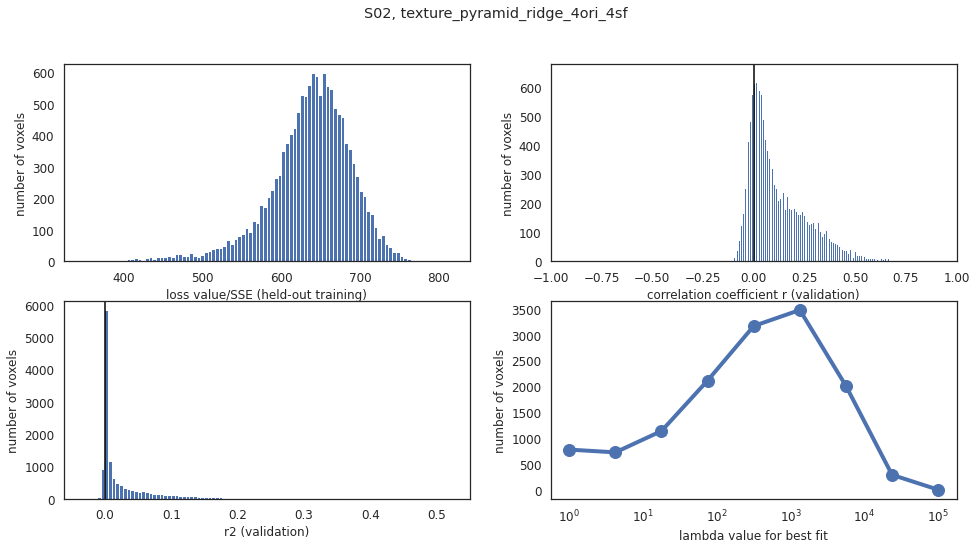

In [11]:
# Plot summary of performance

cclims = [-1,1]
# losslims = [20,120]
losslims = [350,850]
plt.figure(figsize=(16,8));

plt.subplot(2,2,1)
plt.hist(best_losses,100)
# plt.xlim(losslims)
# plt.xlim([500,2000])
plt.xlabel('loss value/SSE (held-out training)');
plt.ylabel('number of voxels');

plt.subplot(2,2,2)
plt.hist(val_cc,100)
# plt.hist(val_cc,100)
# plt.xlim([-0.2, 0.8])
plt.xlim(cclims)
plt.xlabel('correlation coefficient r (validation)');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')

plt.subplot(2,2,3)

# plt.hist(np.sign(val_cc)*val_cc**2,100)
plt.hist(val_r2,100)
# plt.xlim([-0.2, 0.8])
plt.xlabel('r2 (validation)');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')

plt.subplot(2,2,4)

plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');


plt.suptitle('S%02d, %s'%(subject, fitting_type))
plt.savefig(os.path.join(fig_save_folder,'fit_summary.png'))
plt.savefig(os.path.join(fig_save_folder,'fit_summary.pdf'))

In [24]:
val_r2.shape

(14913,)

Text(0.5, 0.98, 'texture_pyramid_ridge_4ori_4sf')

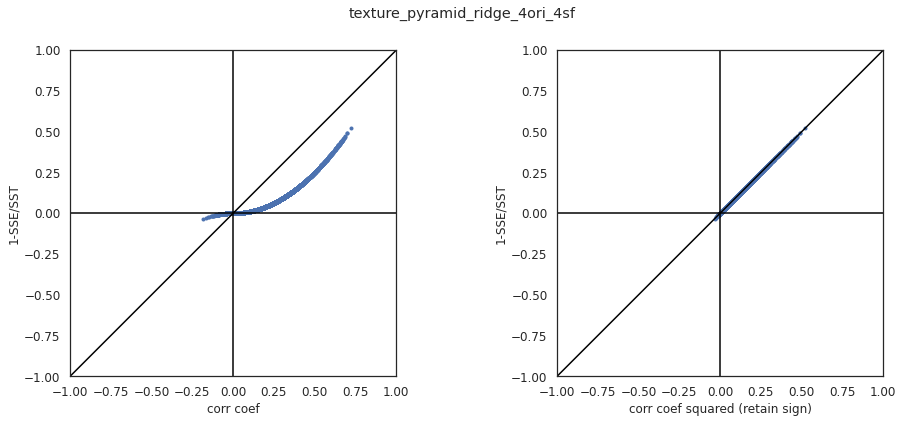

In [12]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1)
plt.plot(val_cc, val_r2, '.')
plt.axhline(0,color='k')
plt.axvline(0,color='k')
plt.plot([-1,1],[-1,1],color='k')
plt.axis('square')
plt.xlabel('corr coef')
plt.ylabel('1-SSE/SST')
plt.ylim([-1,1]); plt.xlim([-1,1])


plt.subplot(1,2,2)
plt.plot(np.sign(val_cc)*val_cc**2, val_r2,'.')
plt.axhline(0,color='k')
plt.axvline(0,color='k')
plt.plot([-1,1],[-1,1],color='k')
plt.axis('square')
plt.xlabel('corr coef squared (retain sign)')
plt.ylabel('1-SSE/SST')
plt.ylim([-1,1]); plt.xlim([-1,1])

plt.suptitle(fitting_type)

Text(0.5, 0.98, 'S02, texture_pyramid_ridge_4ori_4sf')

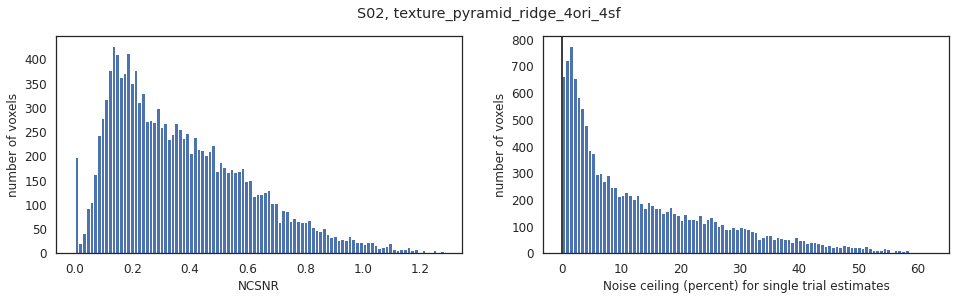

In [13]:
# Plot noise ceiling

plt.figure(figsize=(16,4));

plt.subplot(1,2,1)
plt.hist(voxel_ncsnr,100)
plt.xlabel('NCSNR');
plt.ylabel('number of voxels');

plt.subplot(1,2,2)
plt.hist(noise_ceiling,100)
plt.xlabel('Noise ceiling (percent) for single trial estimates');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')


plt.suptitle('S%02d, %s'%(subject, fitting_type))

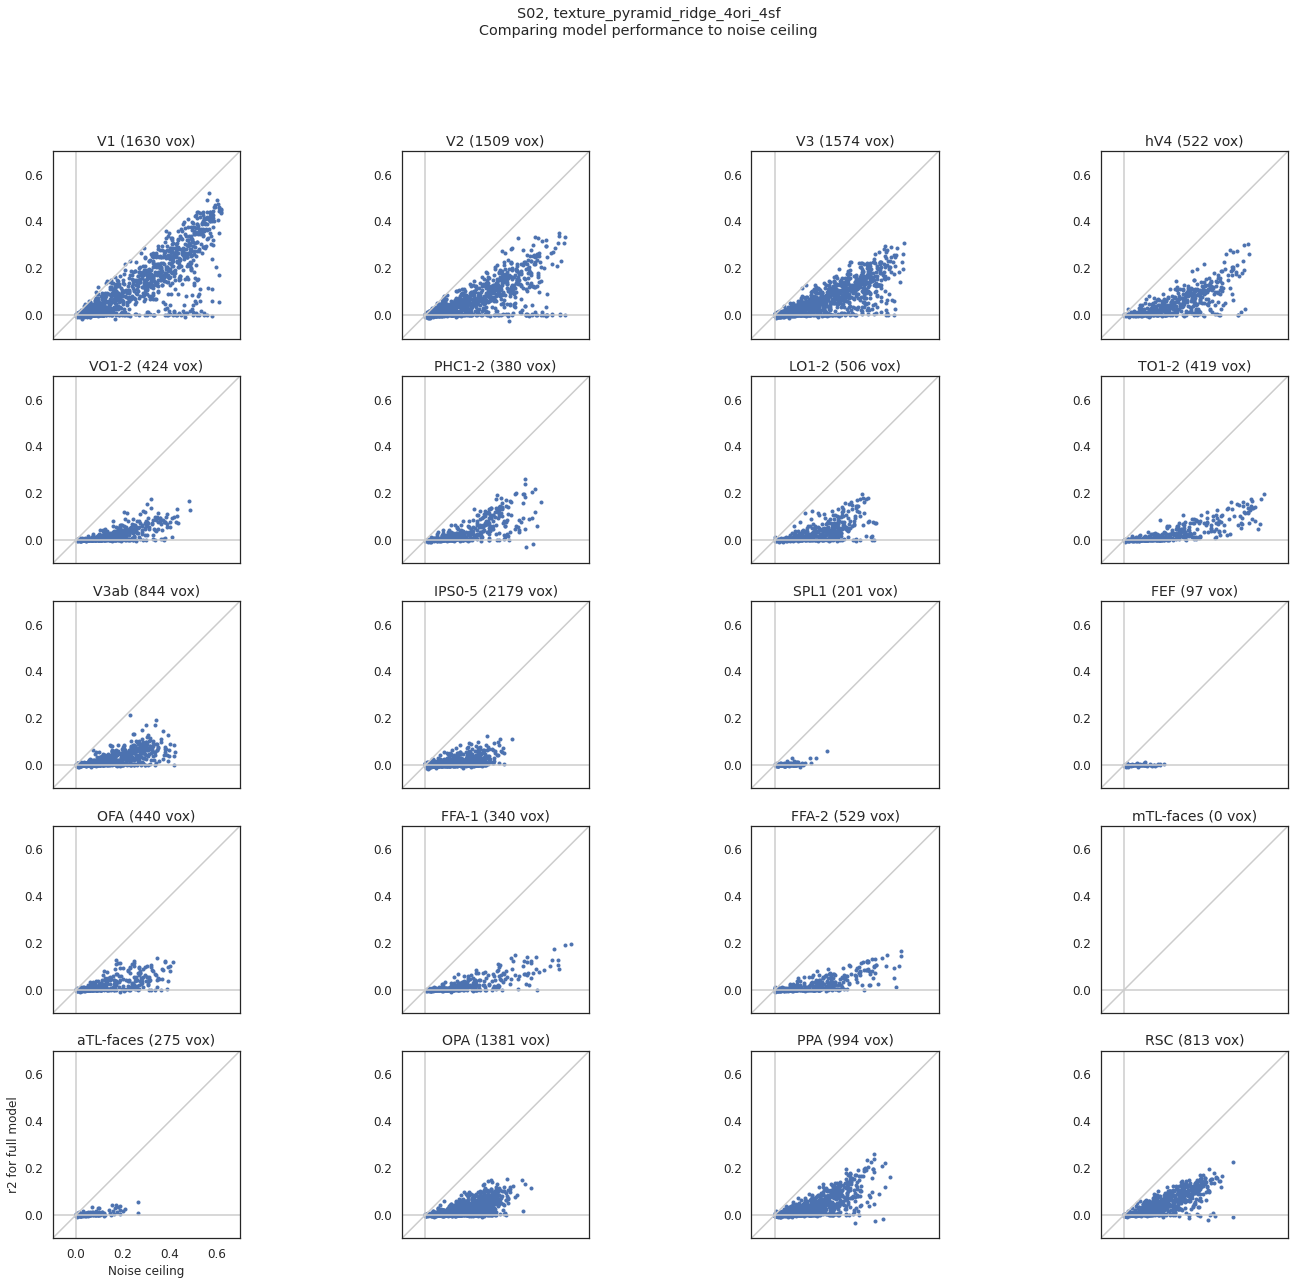

In [14]:
# Scatter plot comparing model prediction to noise ceiling

plt.figure(figsize=(24,20))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

cc_cutoff = -100

xlims = [-0.1, 0.7]
ylims = [-0.1, 0.7]

for rr in range(n_rois):
# for rr in range(1):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
   
    if np.sum(inds2use)>0:
        
        xvals = noise_ceiling[inds2use]/100
        yvals = val_r2[inds2use]

        plt.plot(xvals,yvals,'.')
#         plt.plot(xvals,yvals,'.',color = [0.4, 0.4, 0.4])
#         xvals = xvals[yvals>0.2**2]
#         yvals = yvals[yvals>0.2**2]
#         plt.plot(xvals,yvals,'.',color = 'b')
        
        
    
    if rr==n_rois-4:
        plt.xlabel('Noise ceiling')
        plt.ylabel('r2 for full model')
    else:
        plt.xticks([])
    plt.axis('square')

    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.plot(xlims, ylims, color=[0.8, 0.8, 0.8])
    plt.axvline(color=[0.8, 0.8, 0.8])
    plt.axhline(color=[0.8, 0.8, 0.8])
    
    
    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))

plt.suptitle('S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type))

plt.savefig(os.path.join(fig_save_folder,'r2_vs_noiseceiling.png'))
plt.savefig(os.path.join(fig_save_folder,'r2_vs_noiseceiling.pdf'))

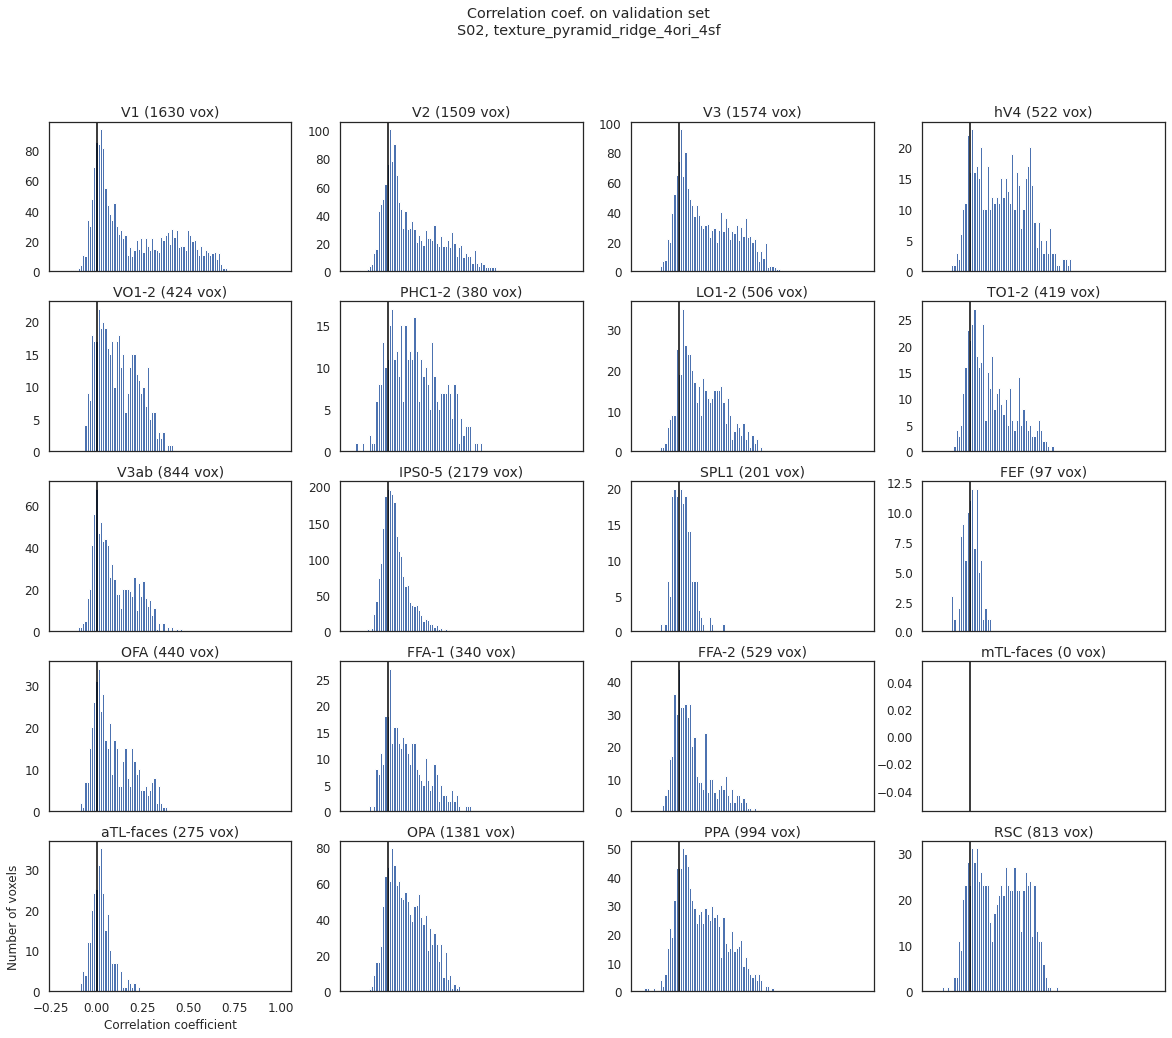

In [15]:
# Plot correlation coefficient for each ROI separately.

plt.figure(figsize=(20,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    plt.subplot(npx,npy,rr+1)

    h = plt.hist(val_cc[inds_this_roi], bins=np.linspace(-0.2,1,100))

    if rr==n_rois-4:
        plt.xlabel('Correlation coefficient')
        plt.ylabel('Number of voxels')
    else:
        plt.xticks([]);
#         plt.yticks([])
        
    plt.axvline(0,color='k')

    plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Correlation coef. on validation set\nS%02d, %s'%(subject, fitting_type));

plt.savefig(os.path.join(fig_save_folder,'corr_each_roi.pdf'))
plt.savefig(os.path.join(fig_save_folder,'corr_each_roi.png'))

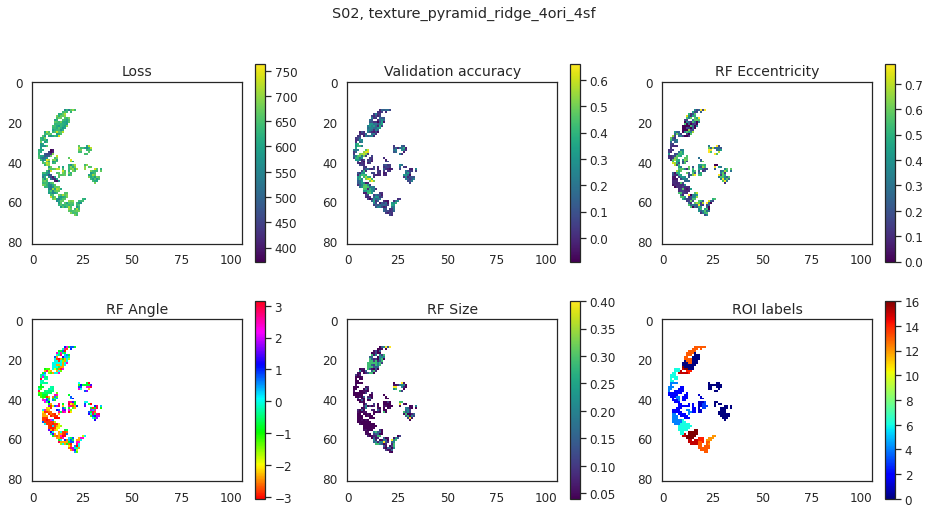

In [16]:
# Visualize some basic properties of pRFs for each voxel, in volume space
# Should be sanity check for dorsal/visual distinctions, esp w/r/t RF angle estimates

sys.path.append(os.path.join(root,'code'))
from utils import file_utility

volume_loss = file_utility.view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = file_utility.view_data(brain_nii_shape, voxel_idx, val_cc)
volume_ecc  = file_utility.view_data(brain_nii_shape, voxel_idx, best_ecc)
volume_ang  = file_utility.view_data(brain_nii_shape, voxel_idx, best_ang)
volume_size = file_utility.view_data(brain_nii_shape, voxel_idx, best_size)
volume_roi = file_utility.view_data(brain_nii_shape, voxel_idx, roi_labels_retino)

slice_idx = 40
fig = plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='viridis', interpolation='None')
plt.colorbar()
plt.subplot(2,3,2)
plt.title('Validation accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='viridis', interpolation='None')
plt.colorbar()
plt.subplot(2,3,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='viridis', interpolation='None')
plt.colorbar()
plt.subplot(2,3,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(2,3,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='viridis', interpolation='None')
plt.colorbar()
plt.subplot(2,3,6)
plt.title('ROI labels')
plt.imshow(volume_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

plt.suptitle('S%02d, %s'%(subject, fitting_type));

plt.savefig(os.path.join(fig_save_folder,'fit_summary_volumespace.pdf'))
plt.savefig(os.path.join(fig_save_folder,'fit_summary_volumespace.png'))

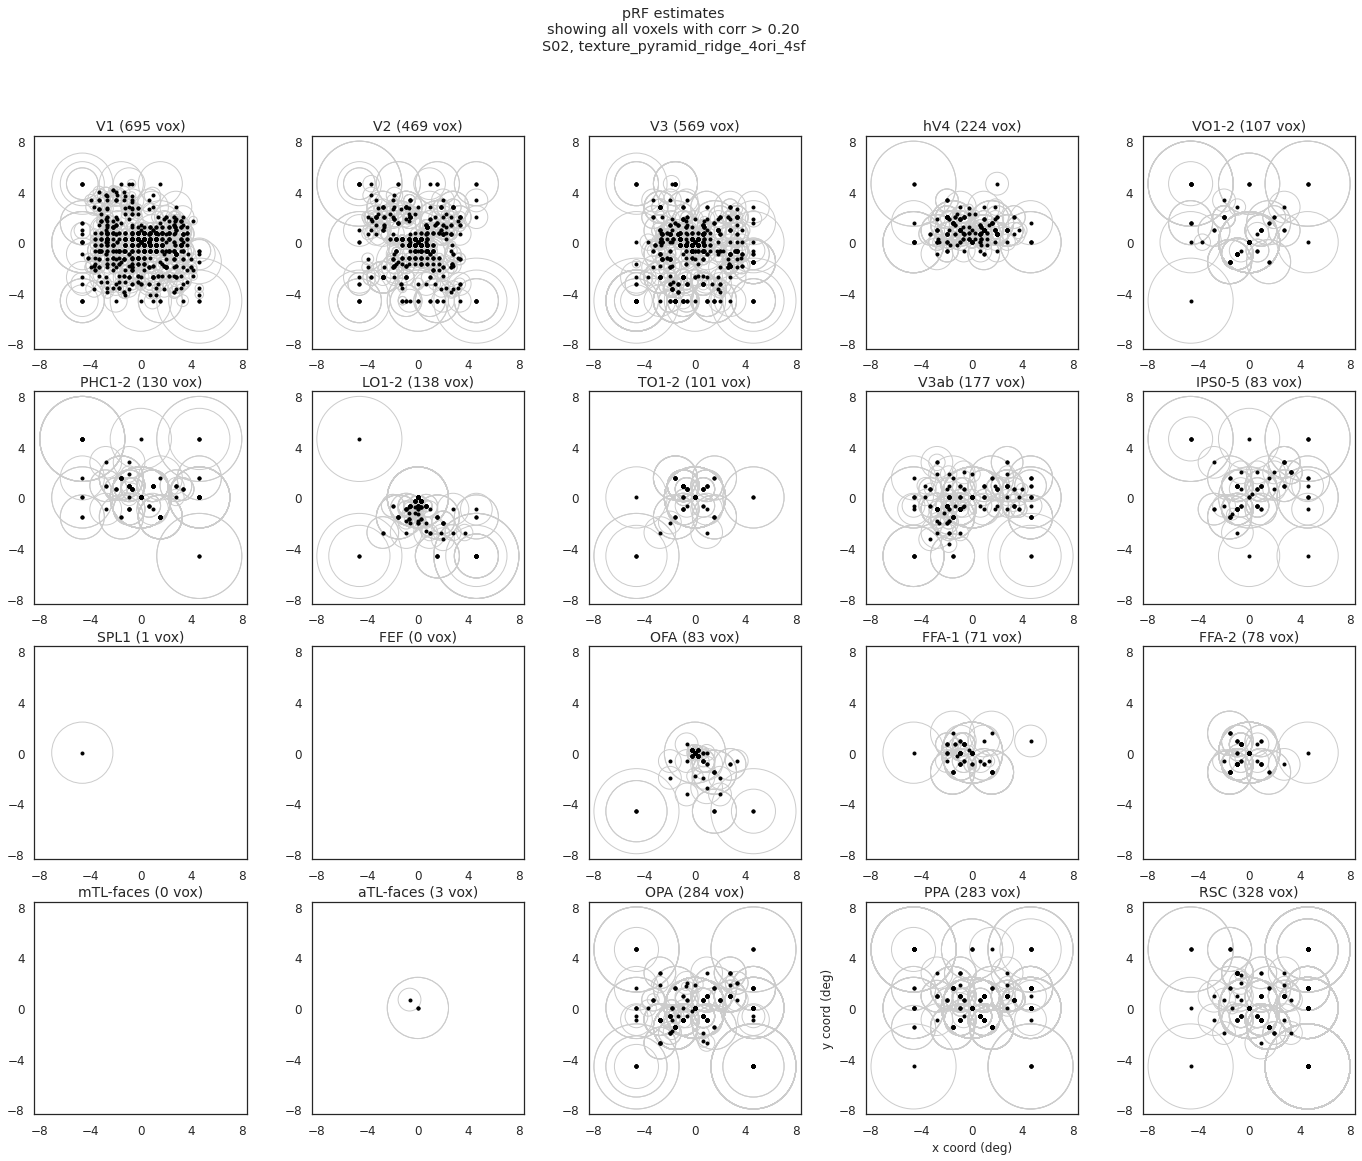

In [17]:
# Plot spatial RF estimates
import matplotlib

eccen_deg = 8.4
best_models_deg = best_models*eccen_deg

plt.figure(figsize=(24,18))

cc_cutoff = 0.20
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil(n_rois/npx))

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
           
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.where(np.logical_and(inds_this_roi, abv_thresh))[0]
    
    plt.subplot(npx,npy,rr+1)
    ax = plt.gca()

    for vi, vidx in enumerate(inds2use):
       
        plt.plot(best_models_deg[vidx,0], best_models_deg[vidx,1],'.',color='k')
        circ = matplotlib.patches.Circle((best_models_deg[vidx,0], best_models_deg[vidx,1]), best_models_deg[vidx,2], color = [0.8, 0.8, 0.8], fill=False)
        ax.add_artist(circ)
   
    plt.axis('square')
    
    plt.xlim([-eccen_deg, eccen_deg])
    plt.ylim([-eccen_deg, eccen_deg])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    if rr==n_rois-2:
        plt.xlabel('x coord (deg)')
        plt.ylabel('y coord (deg)')
    plt.title('%s (%d vox)'%(rname, len(inds2use)))

plt.suptitle('pRF estimates\nshowing all voxels with corr > %.2f\nS%02d, %s'%(cc_cutoff, subject, fitting_type));

plt.savefig(os.path.join(fig_save_folder,'spatial_prf_distrib.pdf'))
plt.savefig(os.path.join(fig_save_folder,'spatial_prf_distrib.png'))

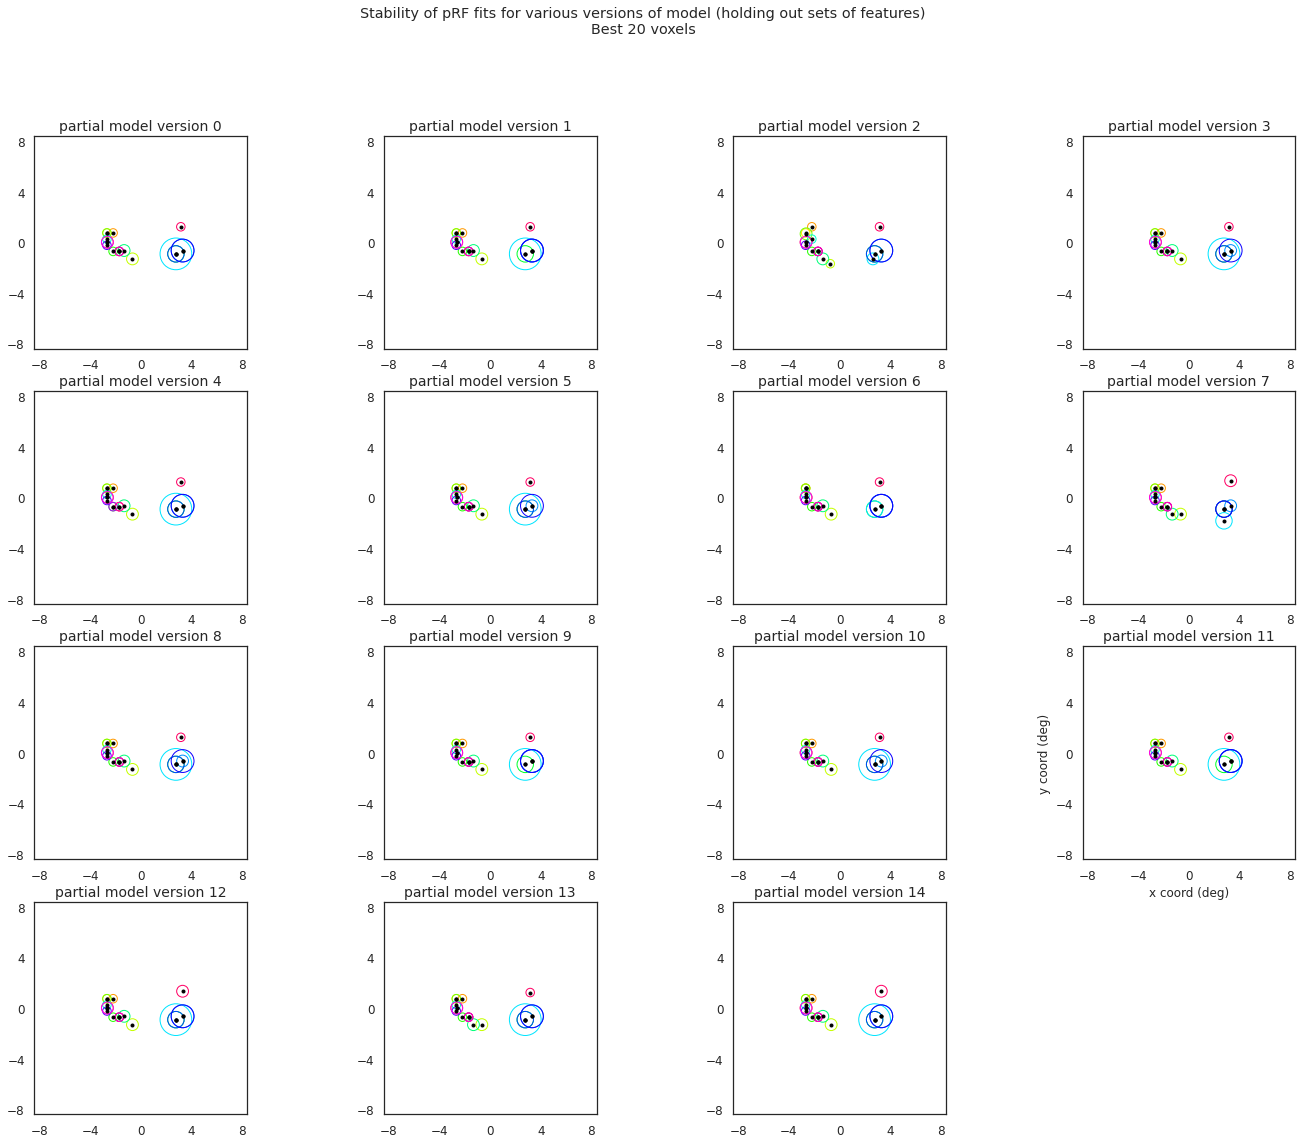

In [18]:
# Plot pRF positions for different partial versions of the model - how stable are they?

plt.figure(figsize=(24,18));
eccen_deg = 8.4
best_models_partial_deg = best_models_partial*eccen_deg

cc_cutoff = 0.20

abv_thresh = val_cc>cc_cutoff   

vox2plot = np.argsort(val_cc)[-20:-1]
colors = cm.hsv(np.linspace(0,1,len(vox2plot)+1))

for pp in range(n_feature_types+1):
    
    plt.subplot(4,4,pp+1)
    ax = plt.gca()

    for vi, vidx in enumerate(vox2plot):
#         if vi>1: 
#             break
       
        plt.plot(best_models_partial_deg[vidx,pp,0], best_models_partial_deg[vidx,pp,1],'.',color='k')
        circ = matplotlib.patches.Circle((best_models_partial_deg[vidx,pp,0], best_models_partial_deg[vidx,pp,1]), \
                                         best_models_partial_deg[vidx,pp,2], color = colors[vi,:], fill=False)
        ax.add_artist(circ)
   
    plt.axis('square')
    
    plt.xlim([-eccen_deg, eccen_deg])
    plt.ylim([-eccen_deg, eccen_deg])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    if pp==n_feature_types-3:
        plt.xlabel('x coord (deg)')
        plt.ylabel('y coord (deg)')
    
    plt.title('partial model version %d'%pp)
    
# plt.suptitle('X coordinate of pRF fits')
# plt.suptitle('Y coordinate of pRF fits')
plt.suptitle('Stability of pRF fits for various versions of model (holding out sets of features)\nBest 20 voxels')

plt.savefig(os.path.join(fig_save_folder,'prf_stability_holdout.pdf'))
plt.savefig(os.path.join(fig_save_folder,'prf_stability_holdout.png'))

['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']


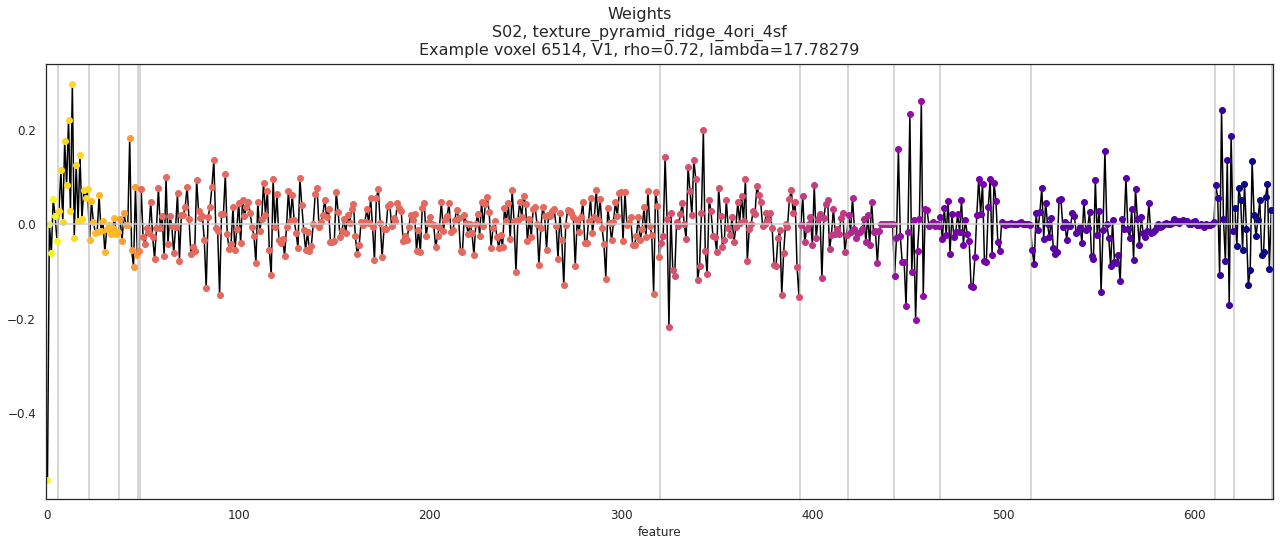

In [19]:
# Plotting weights for all features, choosing one voxel at a time.

from copy import deepcopy

pp=0

vox2plot = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance
# vox2plot = 929

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)
# vox2plot = np.random.randint(0,len(val_cc),1)

vv=vox2plot
plt.figure(figsize=(22,8))

wts = weights[vv,:,pp]
plt.plot(wts,'-',color='k')

lh=[]
f_count=0
for ft in range(n_feature_types):    
    f_count = f_count+np.sum(feature_type_labels==ft)
    plt.axvline(f_count-0.5,color=[0.8, 0.8, 0.8])
    inds = np.where(feature_type_labels==ft)
    h=plt.plot(inds, weights[vv,inds,pp],'o',color=colors[ft,:])
    lh.append(h)
    
plt.axhline(0,color=[0.8, 0.8, 0.8])
# if vi==(npx-1)*npy:
plt.xlabel('feature')
#     plt.ylabel('weight')
# else:
#     plt.xticks([]); 
#     plt.yticks([])

roi_ind_ret = np.where([np.isin(roi_labels_retino[vv], ret_group_inds[ii]) for ii in range(len(ret_group_inds))])[0]
roi_ind_categ = np.where([np.isin(roi_labels_categ[vv], categ_group_inds[ii]) for ii in range(len(categ_group_inds))])[0]
if len(roi_ind_ret)==0:
    rname = categ_group_names[roi_ind_categ[0]]
elif len(roi_ind_categ)==0:
    rname = ret_group_names[roi_ind_ret[0]]
else:
    rname = '%s/%s'%(ret_group_names[roi_ind_ret[0]],categ_group_names[roi_ind_categ[0]])
    
plt.title(''%())
plt.xlim([-1, n_features_total]);
plt.suptitle('Weights\nS%02d, %s\nExample voxel %d, %s, rho=%.2f, lambda=%.5f'%( subject, fitting_type,vv,rname, val_cc[vv],lambdas[best_lambdas[vv]]),fontsize=16);
# plt.legend(lh, feature_type_names)

print(feature_type_names)

In [39]:
feature_type_names

['pixel_stats',
 'mean_magnitudes',
 'mean_realparts',
 'marginal_stats_lowpass_recons',
 'variance_highpass_resid',
 'magnitude_feature_autocorrs',
 'lowpass_recon_autocorrs',
 'highpass_resid_autocorrs',
 'magnitude_within_scale_crosscorrs',
 'real_within_scale_crosscorrs',
 'magnitude_across_scale_crosscorrs',
 'real_imag_across_scale_crosscorrs',
 'real_spatshift_within_scale_crosscorrs',
 'real_spatshift_across_scale_crosscorrs']

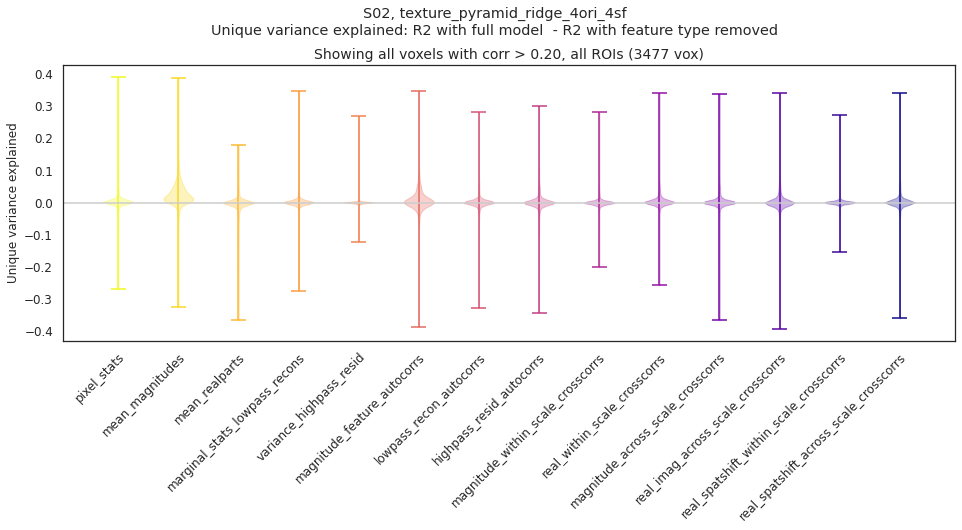

In [20]:
# Distribution of the "unique var explained" by each feature type - the difference in R2 between full model and model excluding that feature class.

plt.figure(figsize=(16,8))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

cc_cutoff = 0.2

abv_thresh = val_cc>cc_cutoff
inds2use = abv_thresh

for ff in range(n_feature_types):
    
    parts = plt.violinplot(var_expl[inds2use,ff], [ff])
    for pc in parts['bodies']:
        pc.set_color(colors[ff,:])
    parts['cbars'].set_color(colors[ff,:])
    parts['cmins'].set_color(colors[ff,:])
    parts['cmaxes'].set_color(colors[ff,:])
    
#     plt.bar(ff, avg_ve[ff], color=colors[ff,:])

plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')
plt.axhline(0, color=[0.8, 0.8, 0.8])
# plt.xlabel('feature type')
plt.ylabel('Unique variance explained')

plt.title('Showing all voxels with corr > %.2f, all ROIs (%d vox)'%(cc_cutoff, np.sum(inds2use)))

plt.suptitle('S%02d, %s\nUnique variance explained: R2 with full model  - R2 with feature type removed'%(subject, fitting_type))
plt.gcf().subplots_adjust(bottom=0.4)
plt.savefig(os.path.join(fig_save_folder,'violin_uniq_var_texturefeat_allrois.png'))
plt.savefig(os.path.join(fig_save_folder,'violin_uniq_var_texturefeat_allrois.pdf'))


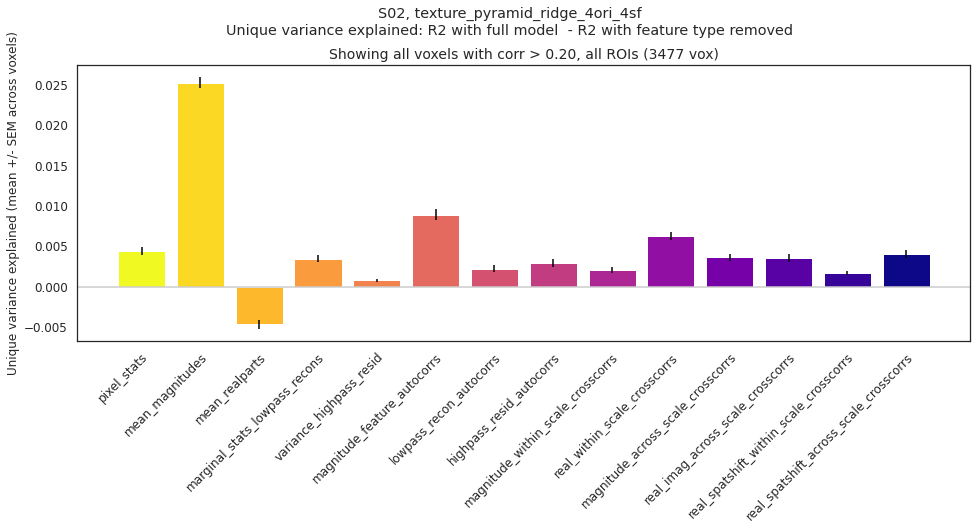

In [21]:
# Distribution of the "unique var explained" by each feature type - the difference in R2 between full model and model excluding that feature class.

plt.figure(figsize=(16,8))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

cc_cutoff = 0.2

abv_thresh = val_cc>cc_cutoff
inds2use = abv_thresh

for ff in range(n_feature_types):
    
    mean = np.mean(var_expl[inds2use,ff])
    sem = np.std(var_expl[inds2use,ff])/np.sqrt(np.sum(inds2use))
    
    plt.bar(ff, mean, color=colors[ff,:])
    plt.errorbar(ff, mean, sem, color = colors[ff,:], ecolor='k')

plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')
plt.axhline(0, color=[0.8, 0.8, 0.8])
# plt.xlabel('feature type')
plt.ylabel('Unique variance explained (mean +/- SEM across voxels)')

plt.title('Showing all voxels with corr > %.2f, all ROIs (%d vox)'%(cc_cutoff, np.sum(inds2use)))

plt.suptitle('S%02d, %s\nUnique variance explained: R2 with full model  - R2 with feature type removed'%(subject, fitting_type))
plt.gcf().subplots_adjust(bottom=0.4)
plt.savefig(os.path.join(fig_save_folder,'uniq_var_texturefeat_allrois.png'))
plt.savefig(os.path.join(fig_save_folder,'uniq_var_texturefeat_allrois.pdf'))


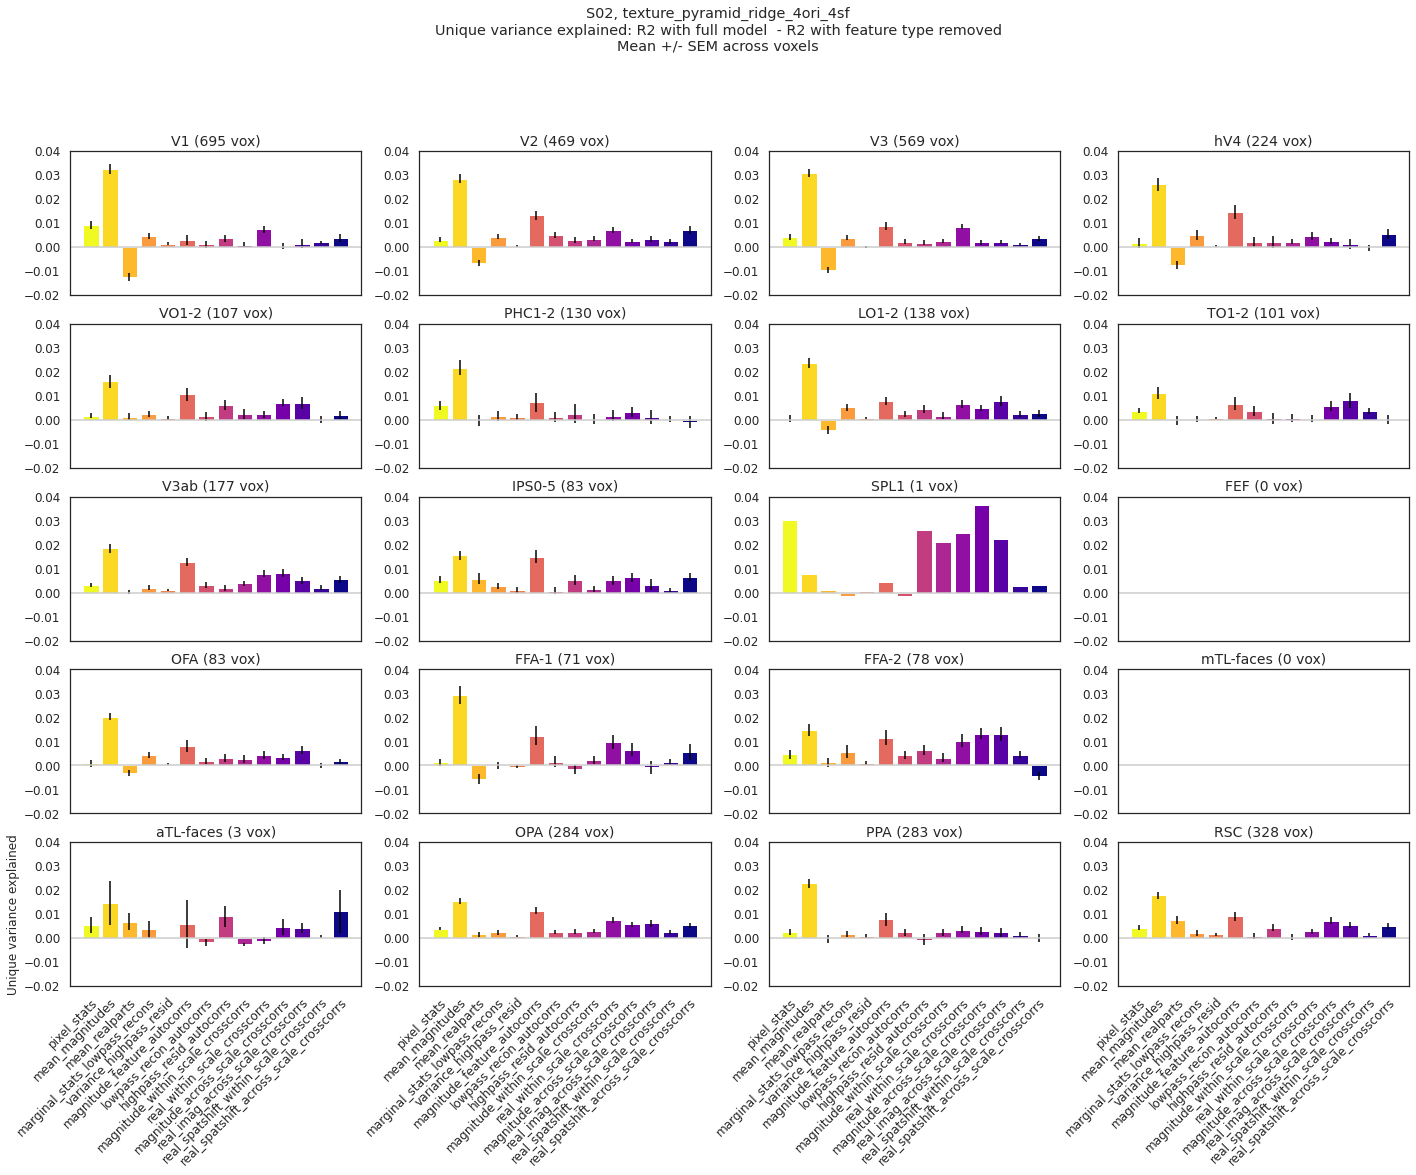

In [22]:
# Preferred feature type, based on unique var explained. Separate plot each ROI.

plt.figure(figsize=(24,20))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

cc_cutoff = 0.2

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    
    plt.subplot(npx,npy,rr+1)
   
    if np.sum(inds2use)>0:
        for ff in range(n_feature_types):
            mean = np.mean(var_expl[inds2use,ff])
            sem = np.std(var_expl[inds2use,ff])/np.sqrt(np.sum(inds2use))
#             sem = np.std(var_expl[inds2use,ff])
    
            plt.bar(ff, mean, color=colors[ff,:])
            plt.errorbar(ff, mean, sem, color = colors[ff,:], ecolor='k')

#     mean_nc = np.mean(noise_ceiling[inds2use]/100)
#     plt.axhline(mean_nc,ls='-',color=[0.8, 0.8, 0.8])
    
            
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.02, 0.04])
    plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')

    if rr==n_rois-4:
        plt.ylabel('Unique variance explained')
    elif rr<n_rois-4:
        plt.xticks([])
#         plt.yticks([])

    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))

plt.suptitle('S%02d, %s\nUnique variance explained: R2 with full model  - R2 with feature type removed\nMean +/- SEM across voxels'%(subject, fitting_type))
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig(os.path.join(fig_save_folder,'uniq_var_texturefeat_eachroi.pdf'))
plt.savefig(os.path.join(fig_save_folder,'uniq_var_texturefeat_eachroi.png'))


Text(0.5, 0.98, 'S02, texture_pyramid_ridge_4ori_4sf\nr2 full_model vs. r2 leave_out_mean_magnitudes')

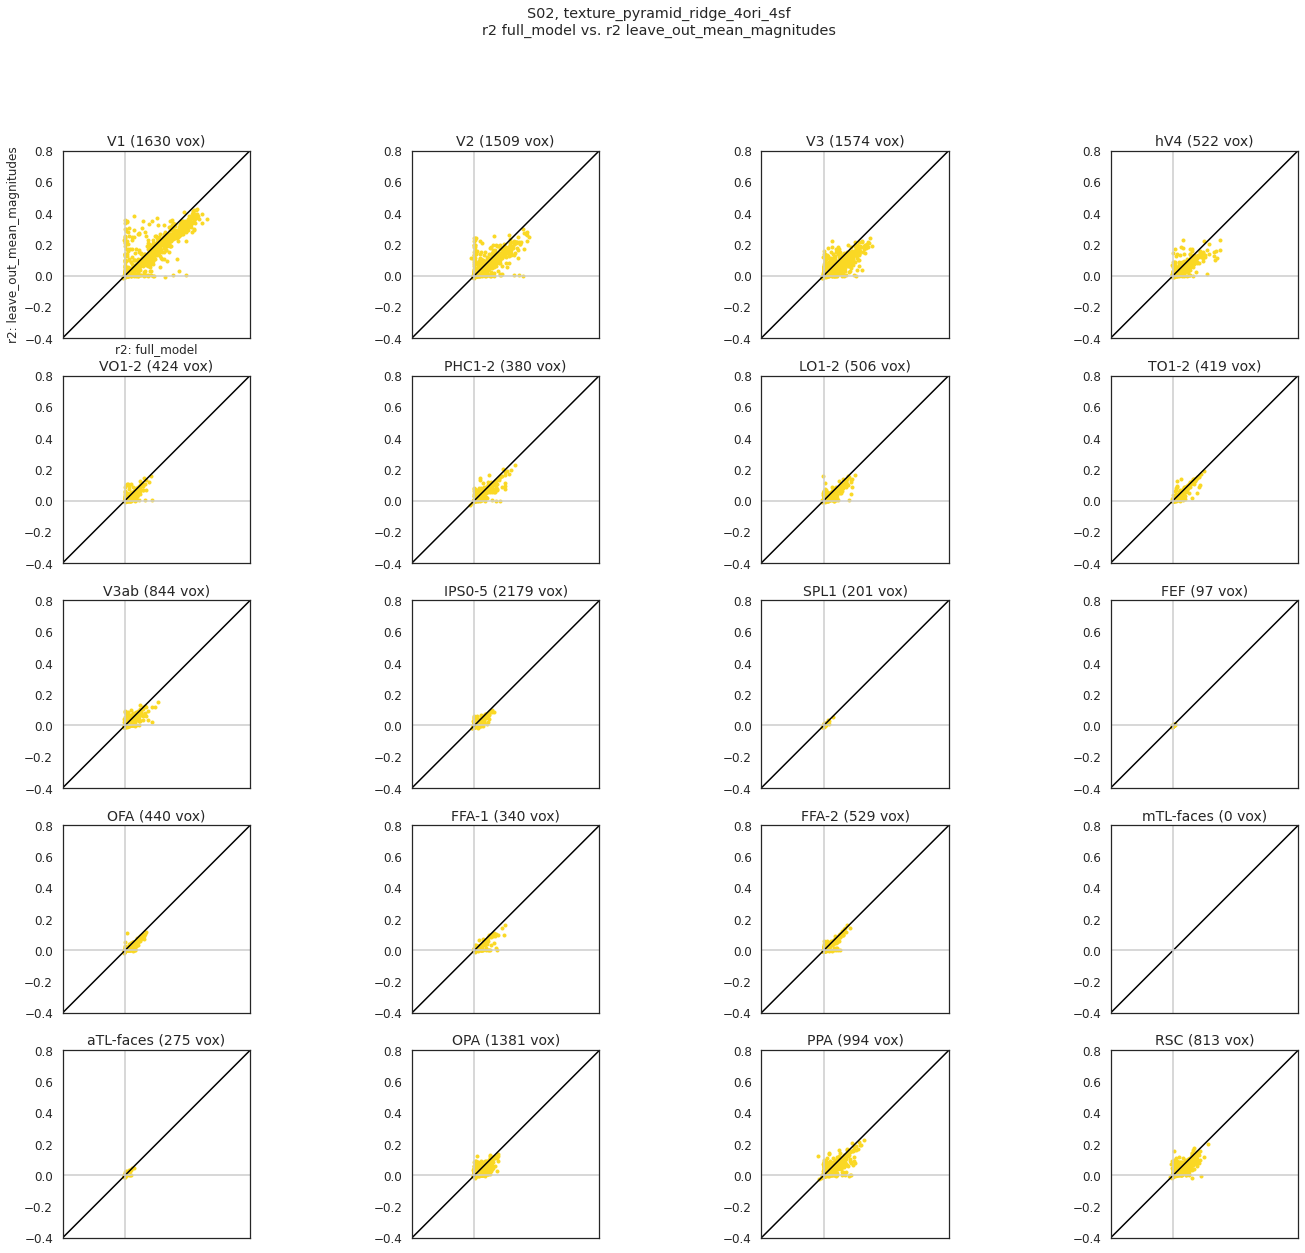

In [25]:
# Scatter plot comparing models

pp1=0; pp2=2

plt.figure(figsize=(24,20))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

cc_cutoff = -100

xlims = [-0.4, 0.8]
ylims = [-0.4, 0.8]

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
   
    if np.sum(inds2use)>0:
        
        xvals = val_r2_partial[inds2use,pp1]
        yvals = val_r2_partial[inds2use,pp2]

        plt.plot(xvals,yvals,'.',color=colors[pp2-1])
    
    if rr==0:
        plt.xlabel('r2: %s'%partial_version_names[pp1])
        plt.ylabel('r2: %s'%partial_version_names[pp2])
    plt.axis('square')

    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.plot(xlims, ylims, color='k')
    plt.axvline(color=[0.8, 0.8, 0.8])
    plt.axhline(color=[0.8, 0.8, 0.8])
    plt.xticks([])
    
    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))

plt.suptitle('S%02d, %s\nr2 %s vs. r2 %s'%(subject, fitting_type, partial_version_names[pp1], partial_version_names[pp2]))


Text(0.5, 0.98, 'S02, texture_pyramid_ridge_4ori_4sf\nFFA-2 (529 vox)')

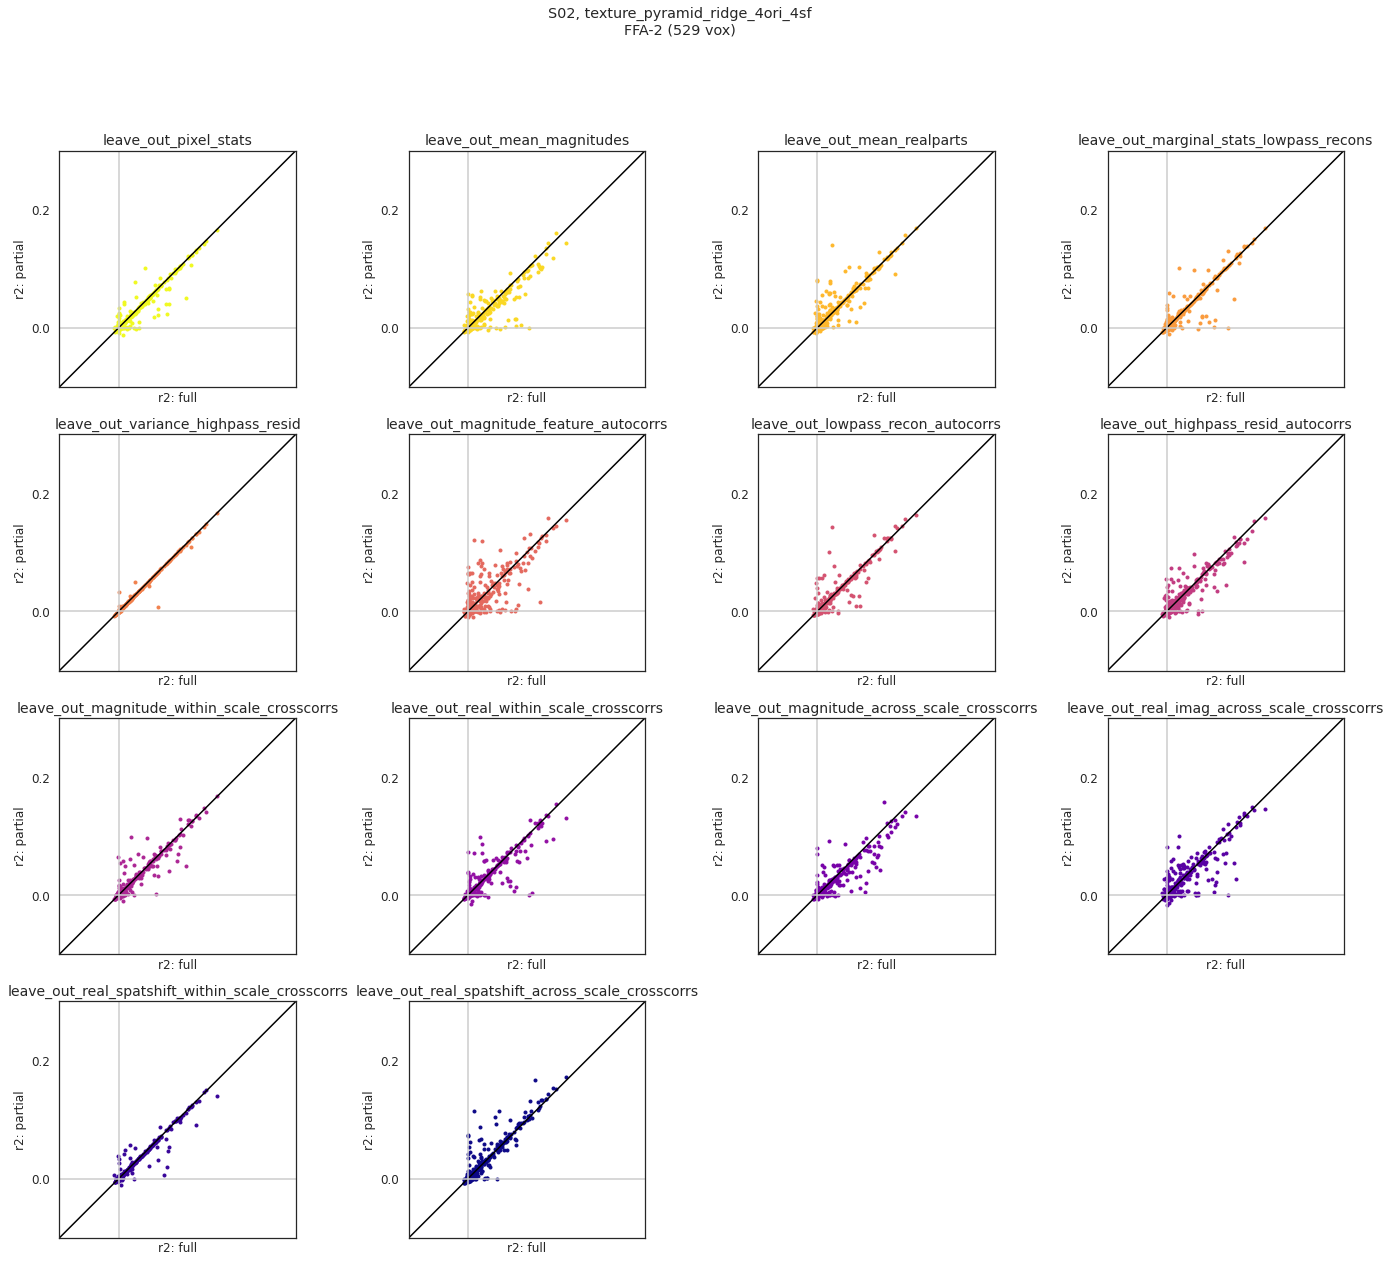

In [28]:
# Scatter plot comparing models

rr = 14

plt.figure(figsize=(24,20))
npx = int(np.ceil(np.sqrt(n_feature_types)))
npy = int(np.ceil(n_feature_types/npx))

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

cc_cutoff = -100

if rr<n_rois_ret:
    inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
    rname = ret_group_names[rr]
else:
    inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
    rname = categ_group_names[rr-n_rois_ret]

abv_thresh = val_cc>cc_cutoff
inds2use = np.logical_and(inds_this_roi, abv_thresh)


xlims = [-0.1, 0.3]
ylims = [-0.1, 0.3]

for ff in range(n_feature_types):
        
    plt.subplot(npx,npy,ff+1);
   
    if np.sum(inds2use)>0:
        
        xvals = val_r2_partial[inds2use,0]
        yvals = val_r2_partial[inds2use,ff+1]

        plt.plot(xvals,yvals,'.',color=colors[ff])
       
    plt.xlabel('r2: full')
    plt.ylabel('r2: partial')
    
    plt.axis('square')

    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.plot(xlims, ylims, color='k')
    plt.axvline(color=[0.8, 0.8, 0.8])
    plt.axhline(color=[0.8, 0.8, 0.8])
    plt.xticks([])
    plt.yticks([0,0.2])
    
    plt.title('%s'%(partial_version_names[ff+1]))

plt.suptitle('S%02d, %s\n%s (%d vox)'%(subject, fitting_type, rname, np.sum(inds2use)))


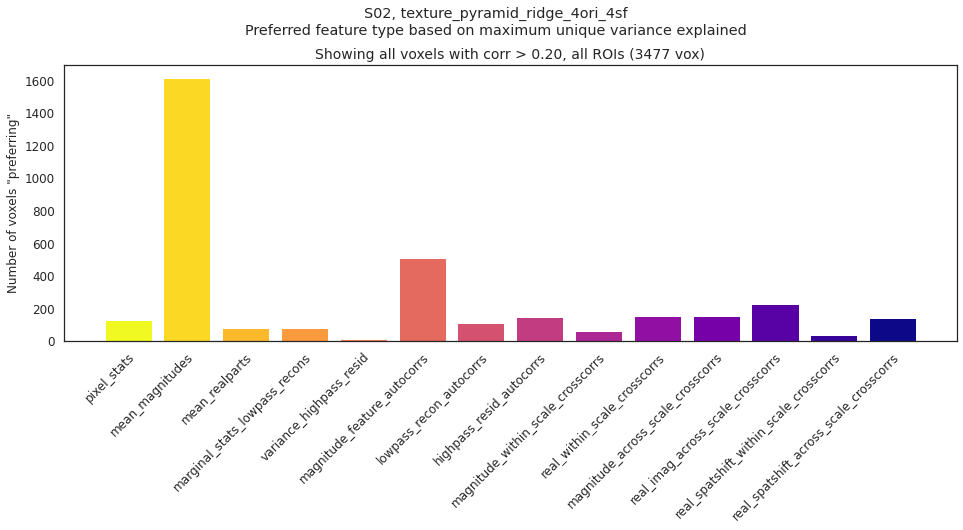

In [29]:
# Preferred feature type based on unique var expl (i.e. reduction in R2 when feature is excluded).

plt.figure(figsize=(16,8))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

max_ve  = feature_adj_labels[np.argmax(var_expl, axis=1)]

cc_cutoff = 0.2

abv_thresh = val_cc>cc_cutoff
inds2use = abv_thresh

unvals = np.arange(0,n_feature_types)
counts = [np.sum(np.logical_and(max_ve==ff, inds2use)) for ff in unvals]

# unvals, counts = np.unique(max_ve[inds2use], return_counts=True)
for ff in range(n_feature_types):
    plt.bar(unvals[ff], counts[ff], color=colors[ff,:])

plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')

# plt.xlabel('feature type')
plt.ylabel('Number of voxels "preferring"')

plt.title('Showing all voxels with corr > %.2f, all ROIs (%d vox)'%(cc_cutoff, np.sum(inds2use)))
plt.gcf().subplots_adjust(bottom=0.4)
plt.suptitle('S%02d, %s\nPreferred feature type based on maximum unique variance explained'%(subject, fitting_type))
plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_allrois.pdf'))
plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_allrois.png'))

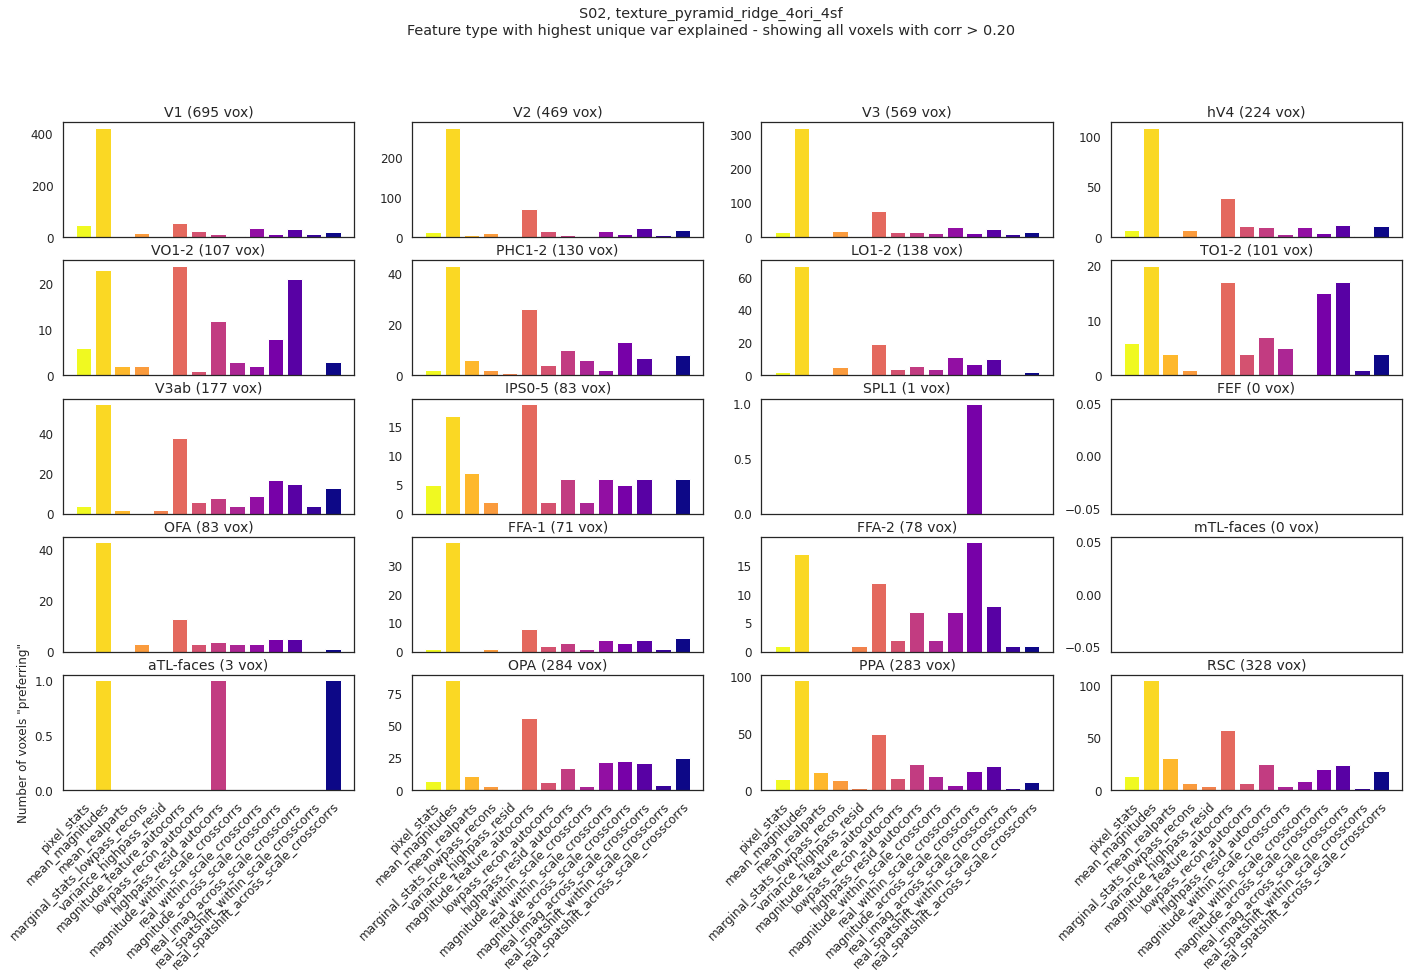

In [30]:
# Preferred feature type, based on unique var explained. Separate plot each ROI.

plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

max_ve  = feature_adj_labels[np.argmax(var_expl, axis=1)]

cc_cutoff = 0.2

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    unvals = np.arange(0,n_feature_types)
    counts = [np.sum(np.logical_and(max_ve==ff, inds2use)) for ff in unvals]

    plt.subplot(npx,npy,rr+1)
   
    for ff in range(len(unvals)):
        plt.bar(unvals[ff], counts[ff], color=colors[ff,:])
 
    plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')

    if rr==n_rois-4:
        plt.ylabel('Number of voxels "preferring"')
    elif rr<n_rois-4:
        plt.xticks([])
#         plt.yticks([])

    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))

# plt.suptitle('S%02d, %s\nFeature type where max weight occured - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
plt.suptitle('S%02d, %s\nFeature type with highest unique var explained - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_eachroi.pdf'))
plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_eachroi.png'))


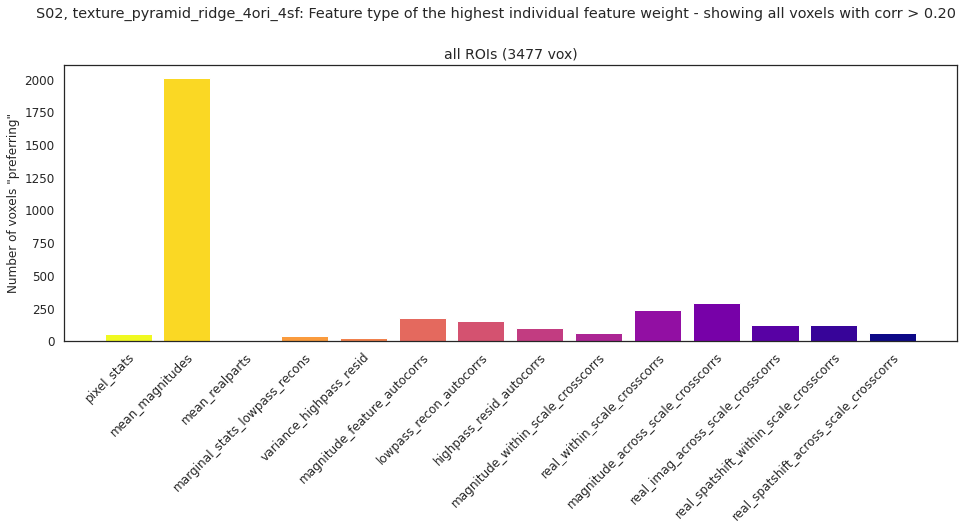

In [31]:
# Preferred feature type, based on highest encoding model weights.

fig = plt.figure(figsize=(16,8))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

# mean_weight_each_type = np.concatenate([np.expand_dims(np.mean(weights[:,feature_type_labels==ff], axis=1),axis=1) for ff in range(len(feature_type_names))], axis=1)
# max_wt = np.argmax(mean_weight_each_type, axis=1)

max_wt = feature_type_labels[np.argmax(weights[:,:,0],axis=1)]

cc_cutoff = 0.2

abv_thresh = val_cc>cc_cutoff
inds2use = abv_thresh

unvals = np.arange(0,n_feature_types)
counts = [np.sum(np.logical_and(max_wt==ff, inds2use)) for ff in unvals]

# unvals, counts = np.unique(max_wt[inds2use], return_counts=True)
for ff in range(n_feature_types):
    plt.bar(unvals[ff], counts[ff], color=colors[ff,:])

plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')
# plt.xlabel('feature type')
plt.ylabel('Number of voxels "preferring"')

plt.title('all ROIs (%d vox)'%( np.sum(inds2use)))

plt.suptitle('S%02d, %s: Feature type of the highest individual feature weight - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
# plt.suptitle('S%02d, %s: Feature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
plt.gcf().subplots_adjust(bottom=0.4)
plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features_allrois.pdf'))
plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features_allrois.png'))

In [36]:
feature_type_labels[0]

0

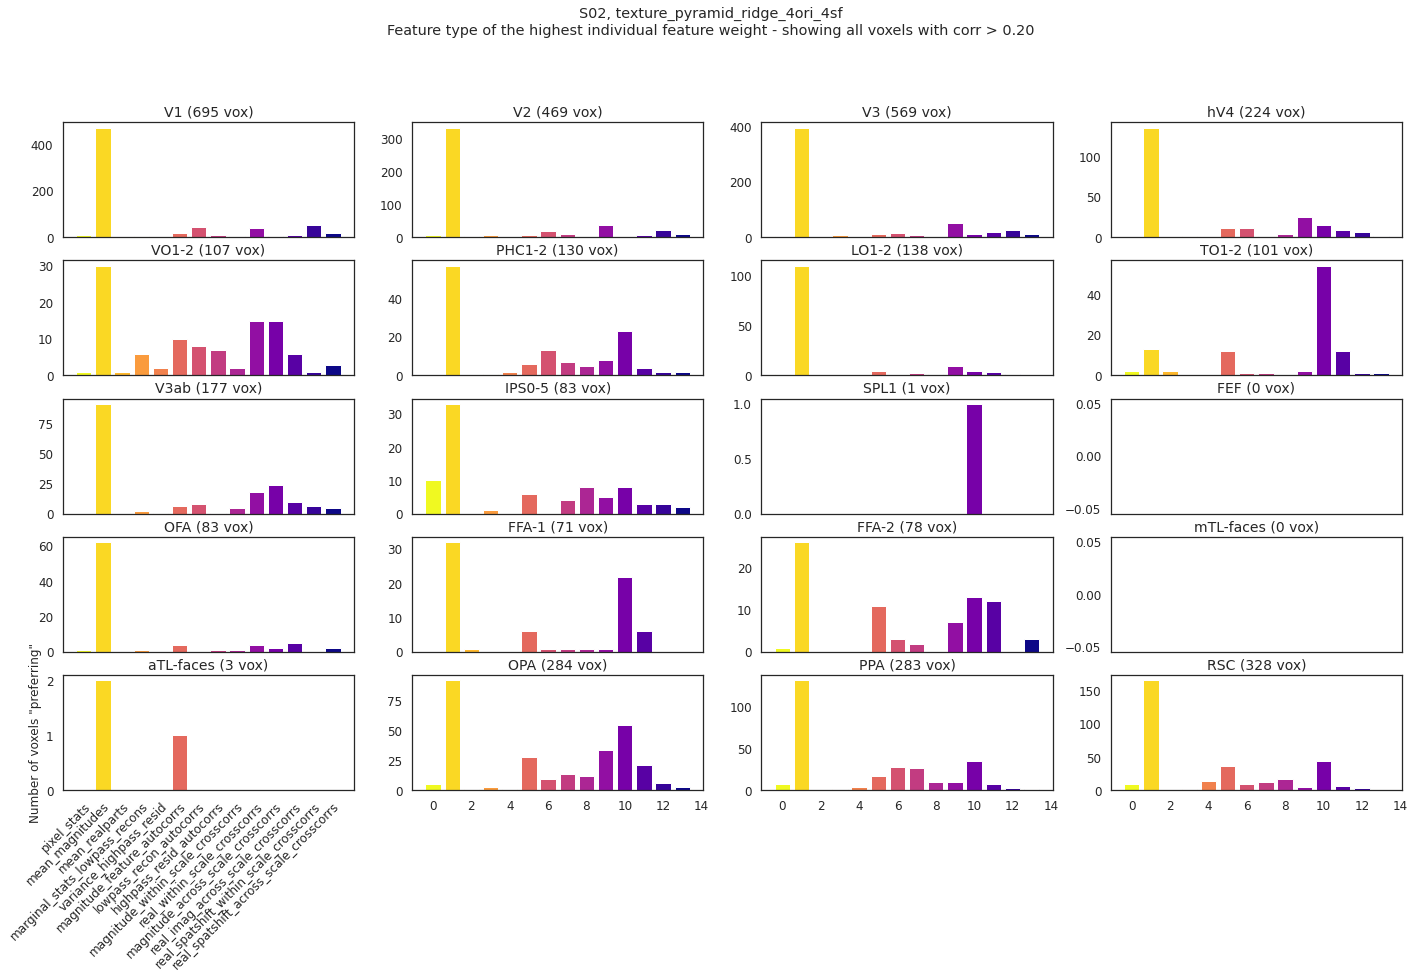

In [32]:
# Preferred feature type, based on encoding model weights. Separate plot each ROI.

fig = plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

# mean_weight_each_type = np.concatenate([np.expand_dims(np.mean(weights[:,feature_type_labels==ff], axis=1),axis=1) for ff in range(len(feature_type_names))], axis=1)
# max_wt = np.argmax(mean_weight_each_type, axis=1)

max_wt = feature_type_labels[np.argmax(weights[:,:,0],axis=1)]

cc_cutoff = 0.2

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
#     unvals, counts = np.unique(max_wt[inds2use], return_counts=True)
    unvals = np.arange(0,n_feature_types)
    counts = [np.sum(max_wt[inds2use]==ff) for ff in range(n_feature_types)]
    for ff in range(len(unvals)):
        plt.bar(unvals[ff], counts[ff], color=colors[ff,:])
 
    
    if rr==n_rois-4:
        plt.ylabel('Number of voxels "preferring"')
        plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')
#         fig.autofmt_xdate()
    elif rr<n_rois-4:
        plt.xticks([])
#         plt.yticks([])

    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))

plt.suptitle('S%02d, %s\nFeature type of the highest individual feature weight - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
# plt.suptitle('S%02d, %s\nFeature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features.pdf'))
plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features.png'))



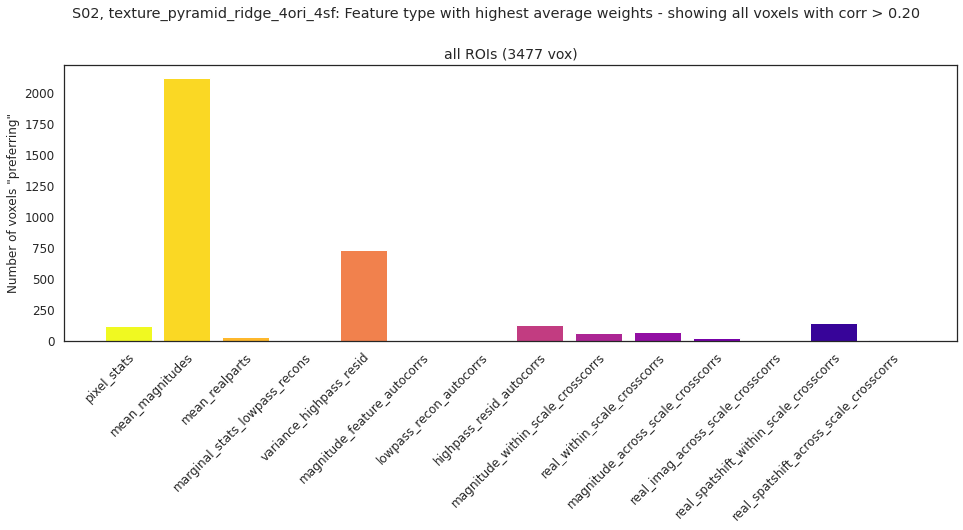

In [33]:
# Preferred feature type, based on highest average encoding model weights.

fig = plt.figure(figsize=(16,8))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

mean_weight_each_type = np.concatenate([np.expand_dims(np.mean(weights[:,feature_type_labels==ff,0], axis=1),axis=1) for ff in range(len(feature_type_names))], axis=1)
max_wt = np.argmax(mean_weight_each_type, axis=1)

# max_wt = feature_type_labels[np.argmax(weights[:,:,0],axis=1)]

cc_cutoff = 0.2

abv_thresh = val_cc>cc_cutoff
inds2use = abv_thresh

unvals = np.arange(0,n_feature_types)
counts = [np.sum(np.logical_and(max_wt==ff, inds2use)) for ff in unvals]

# unvals, counts = np.unique(max_wt[inds2use], return_counts=True)
for ff in range(n_feature_types):
    plt.bar(unvals[ff], counts[ff], color=colors[ff,:])

plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')
# plt.xlabel('feature type')
plt.ylabel('Number of voxels "preferring"')

plt.title('all ROIs (%d vox)'%( np.sum(inds2use)))

plt.suptitle('S%02d, %s: Feature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
# plt.suptitle('S%02d, %s: Feature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
plt.gcf().subplots_adjust(bottom=0.4)
# plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features_allrois.pdf'))
# plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features_allrois.png'))

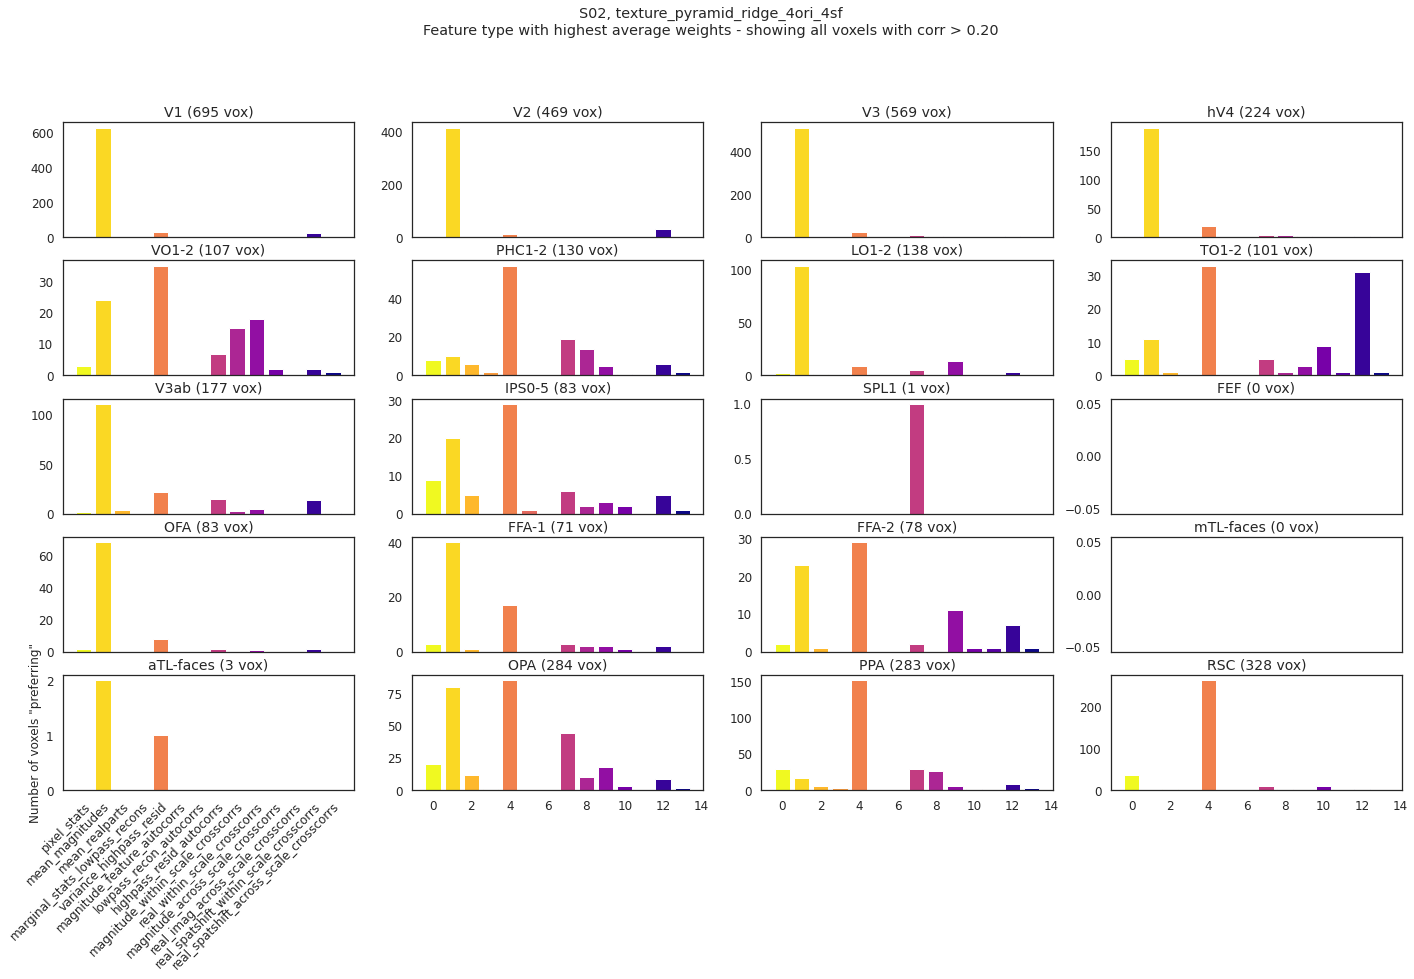

In [34]:
# Preferred feature type, based on encoding model weights. Separate plot each ROI.

fig = plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)

mean_weight_each_type = np.concatenate([np.expand_dims(np.mean(weights[:,feature_type_labels==ff,0], axis=1),axis=1) for ff in range(len(feature_type_names))], axis=1)
max_wt = np.argmax(mean_weight_each_type, axis=1)

# max_wt = feature_type_labels[np.argmax(weights[:,:,0],axis=1)]

cc_cutoff = 0.2

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
#     unvals, counts = np.unique(max_wt[inds2use], return_counts=True)
    unvals = np.arange(0,n_feature_types)
    counts = [np.sum(max_wt[inds2use]==ff) for ff in range(n_feature_types)]
    for ff in range(len(unvals)):
        plt.bar(unvals[ff], counts[ff], color=colors[ff,:])
 
    
    if rr==n_rois-4:
        plt.ylabel('Number of voxels "preferring"')
        plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')
#         fig.autofmt_xdate()
    elif rr<n_rois-4:
        plt.xticks([])
#         plt.yticks([])

    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))

plt.suptitle('S%02d, %s\nFeature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
# plt.suptitle('S%02d, %s\nFeature type with highest average weights - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));
plt.gcf().subplots_adjust(bottom=0.3)
# plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features.pdf'))
# plt.savefig(os.path.join(fig_save_folder,'hist_highest_wt_features.png'))



In [41]:
weights.shape

(14913, 641, 15)